# Evaluate our current models on different datasets for clustering

In [1]:
%load_ext autoreload
%autoreload 2

### Amazon Reviews Dataset

In [2]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from datasets import load_dataset

dataset = load_dataset("amazon_polarity", split="train")
dataset = dataset.shuffle(seed=916).select(range(100000))

In [4]:
dataset

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 100000
})

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("cayjobla/all-mpnet-base-v2-compressed")

/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
def tokenize(batch):
    return tokenizer(batch["content"], truncation=True, padding="max_length", return_tensors="pt")

tokenized = dataset.map(tokenize, batched=True, batch_size=1000, remove_columns=dataset.column_names).with_format("torch")

In [7]:
tokenized

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 100000
})

In [8]:
from reduced_encoders import MPNetCompressedModel

model = MPNetCompressedModel.from_pretrained("cayjobla/all-mpnet-base-v2-compressed").to(device)

/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [9]:
def encode(batch):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
    return {"reduced": outputs.last_hidden_state.cpu().detach(), 
            "full": outputs.unreduced_pooler_output.cpu().detach()}

embeddings = tokenized.map(encode, batched=True, batch_size=100, remove_columns=tokenized.column_names).with_format("torch")

In [10]:
embeddings

Dataset({
    features: ['reduced', 'full'],
    num_rows: 100000
})

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import string

def clean_text(batch):
    word_tokenize = RegexpTokenizer(r"\w+").tokenize
    stop_words = set(stopwords.words("english"))

    word_tokens = [word_tokenize(text.lower()) for text in batch["content"]]
    return {"words": [[word for word in words if word not in stop_words] for words in word_tokens]}

cleaned = dataset.map(clean_text, batched=True, batch_size=1000, remove_columns=["content", "title"]).with_format("torch")

## Embedding Analysis

### Distribution of distances between embeddings

In [9]:
from matplotlib import pyplot as plt
import numpy as np

In [10]:
X = embeddings["reduced"].numpy()[:10000]
print("Std:", np.std(X))

Std: 0.041911896


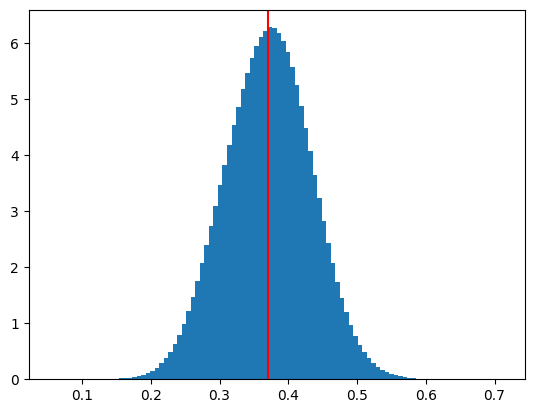

Mean: 0.3708664460270922
Std: 0.0625143774799992


In [11]:
from scipy.spatial.distance import pdist

distances = pdist(X)
plt.hist(distances, bins=100, density=True)
plt.axvline(distances.mean(), color="red", label="mean")
plt.show()

print("Mean:", distances.mean())
print("Std:", distances.std())

### Distribution of number of epsilon neighbors

2.3632


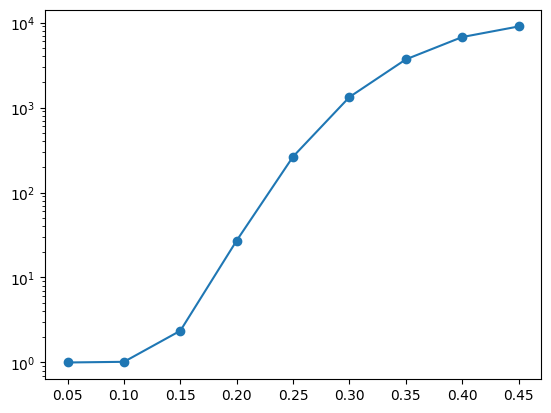

In [12]:
from scipy.spatial.distance import cdist

X = embeddings["reduced"].numpy()[:10000]
distances = cdist(X, X)
print(np.sum(distances < .15, axis=1).mean())

epsilon = np.arange(0.05, 0.5, 0.05)
mean_nn = [np.sum(distances < eps, axis=1).mean() for eps in epsilon]
plt.semilogy(epsilon, mean_nn, marker="o")
plt.show()

## Test the c-TF-IDF part of the micro-clusters

In [22]:
from denstream import DenStreamMicroCluster
import numpy as np

mc = DenStreamMicroCluster(
    X = embeddings["reduced"][0].numpy(),
    documents = np.array(cleaned["words"][0]),
    timestamp = 0,
    decaying_factor = 0.25,
    term_threshold = 0.5,
)

In [24]:
# Basic Test (No decaying)
for x, words in zip(embeddings["reduced"][1:100], cleaned["words"][1:100]):
    mc.insert(x.numpy(), document=np.array(words), timestamp=0)

In [25]:
print("Weight:", mc.calc_weight(mc.last_edit_time))
print("Term Weight:", mc._term_w)
print("Terms:", mc.tf)
print("Num terms:", len(mc.tf))

Weight: 100.0
Term Weight: 3520.0
Terms: {"'ll": 4, '4': 2, 'bad': 7, 'book': 54, 'cliffhanger': 1, 'dark': 1, 'done': 3, 'drawing': 1, 'ending': 1, 'fills': 1, 'finished': 1, 'first': 9, 'gets': 2, 'installment': 1, "n't": 57, 'next': 5, 'pretty': 4, 'put': 5, 'read': 9, 'series': 2, 'seven': 1, 'smoothly': 1, 'story': 7, 'teeth': 1, 'tell': 7, 'though': 7, 'three': 3, 'time': 14, 'tower': 1, 'transition': 1, 'wait': 4, 'ya': 1, 'years': 4, 'adventure': 2, 'come': 3, 'cost': 3, 'dreaming': 1, 'exciting': 1, 'fulfilling': 1, 'great': 24, 'high': 4, 'life': 4, 'living': 1, 'make': 10, 'movie': 16, 'opportunity': 1, 'rich': 1, 'scary': 1, 'something': 4, 'sometimes': 2, 'things': 5, 'unknown': 1, 'back': 7, 'breathe': 1, 'buy': 12, 'cd': 5, 'chillin': 1, 'excellent': 2, 'favorite': 3, 'freeker': 1, 'go': 5, 'guitar': 2, 'hit': 1, 'keller': 1, 'kidney': 1, 'like': 17, 'listen': 2, 'live': 1, 'one': 32, 'others': 3, 'par': 1, 'personal': 1, 'plays': 1, 'quite': 12, 'shows': 3, 'sitting': 1

In [26]:
# Decaying Test
t = 0
for i, (x, words) in enumerate(zip(embeddings["reduced"][100:200], cleaned["words"][100:200])):
    if i % 20 == 0:
        t += 1
    mc.insert(x.numpy(), document=np.array(words), timestamp=t)

In [27]:
print("Weight:", mc.calc_weight(mc.last_edit_time))
print("Term Weight:", mc._term_w)
print("Terms:", mc.tf)
print("Num terms:", len(mc.tf))

Weight: 114.89695584151816
Term Weight: 4564.379645010528
Terms: {"'ll": 4.181792830507428, '4': 0.8408964152537143, 'bad': 6.491140649828261, 'book': 59.26125471457535, 'done': 2.7613446228805714, 'finished': 1.0150517651282176, 'first': 11.749637371653224, 'gets': 4.397716731568432, "n't": 63.0808224891498, 'next': 4.403951376822194, 'pretty': 4.483503169195336, 'put': 6.150244234574548, 'read': 14.72808553483633, 'series': 3.048003196440262, 'story': 10.438844486655947, 'tell': 2.9431374533879997, 'though': 5.219533841396789, 'three': 3.8093478193208328, 'time': 17.340811954659152, 'wait': 2.681792830507429, 'years': 7.3332167043235055, 'adventure': 1.6817928305074288, 'come': 3.102241038134286, 'cost': 1.7613446228805711, 'exciting': 1.1275549888134047, 'great': 30.898394310254048, 'high': 3.1817928305074283, 'life': 5.665295999702765, 'living': 1.1275549888134047, 'make': 11.123485218218983, 'movie': 17.722297281857834, 'rich': 1.0150517651282176, 'something': 4.617292803262503, '

## Cluster

### Test micro-cluster in High Dimensions

In [13]:
from sklearn.datasets import make_blobs

# Generate toy data
centers = np.zeros(48)

toy_data, _ = make_blobs(
    n_samples=1000, 
    centers=centers.reshape(1,-1),
    cluster_std=0.04,
)

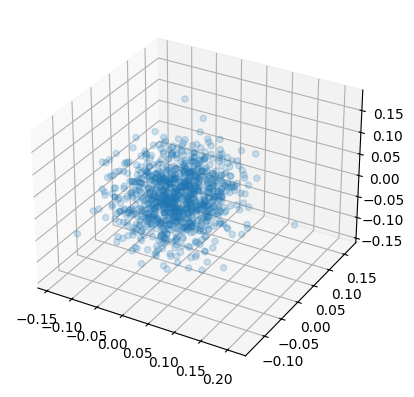

In [14]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

# Visualize toy data
pca = PCA(n_components=3)
toy_data_3d = pca.fit_transform(toy_data)
# Create 3d axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*toy_data_3d.T, alpha=0.2)
plt.show()

Weight: 1.0
Radius: 0.2673914464383583


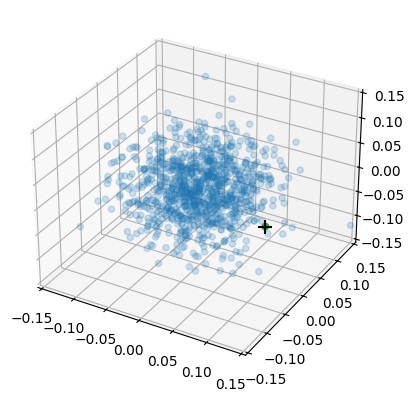

In [15]:
from denstream import DenStreamMicroCluster

epsilon = 0.2
data_gen = (x for x in toy_data)
mc = DenStreamMicroCluster(
    X = next(data_gen),
    timestamp = 0,
    decaying_factor = 0.25,
)
i = 0
in_cluster = np.zeros(len(toy_data), dtype=bool)
in_cluster[i] = True

print("Weight:", mc.calc_weight(0))
print("Radius:", mc.radius)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.scatter(*toy_data_3d[~in_cluster].T, c='C0', alpha=0.2, zorder=1)
ax.scatter(*toy_data_3d[i], c='C2', zorder=3)
center_3d = pca.transform(mc.center.reshape(1,-1))
ax.scatter(*center_3d.T, marker='+', color='k', s=100, zorder=4)
# circle = plt.Circle(center_2d[0], mc.radius, fill=False, color='k', zorder=10)
# ax.add_patch(circle)
ax.set_xlim(-.15,.15)
ax.set_ylim(-.15,.15)
ax.set_zlim(-.15,.15)
plt.show()

Weight: 47.0
Radius: 0.09659224311642355
Accepted


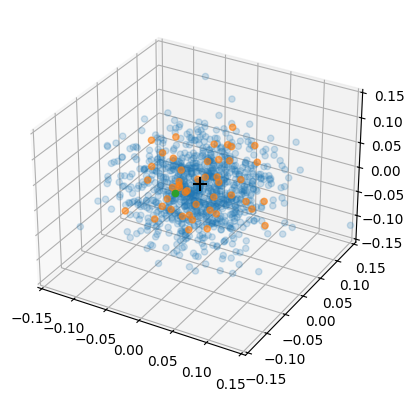

In [61]:
import copy

updated_mc = copy.deepcopy(mc)
updated_mc.insert(next(data_gen), 0)
i += 1

print("Weight:", updated_mc.calc_weight(0))
print("Radius:", updated_mc.radius)
if updated_mc.radius <= epsilon:
    print("Accepted")
    mc = updated_mc
    in_cluster[i] = True
else:
    print("Rejected")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.scatter(*toy_data_3d[~in_cluster].T, c='C0', alpha=0.2, zorder=1)
ax.scatter(*toy_data_3d[in_cluster].T, c='C1', alpha=0.6, zorder=2)
ax.scatter(*toy_data_3d[i], c='C2', zorder=3)
center_3d = pca.transform(updated_mc.center.reshape(1,-1))
ax.scatter(*center_3d.T, marker='+', color='k', s=100, zorder=4)
ax.set_xlim(-.15,.15)
ax.set_ylim(-.15,.15)
ax.set_zlim(-.15,.15)
plt.show()

The circular area of the above cannot be reflective of the actual micro-cluster, since the data is in high dimensions.

### DenStream

In [52]:
from denstream import DenStream

denstream = DenStream(
    decaying_factor=0.25,
    beta=0.75,
    mu=2.,
    epsilon=.1,
    stream_speed=500,
    term_threshold=0.7,
)

In [53]:
X = embeddings["reduced"].numpy()[:2500]
documents = cleaned["words"][:2500]

for x, words in zip(X, documents):
    denstream.learn_one(x, words)

In [54]:
len(denstream.o_micro_clusters)

1

In [55]:
len(denstream.p_micro_clusters)

136

#### Quick c-TF-IDF Check

In [56]:
denstream._recluster()
denstream.n_clusters

11

In [57]:
tfidf, terms = denstream.c_tf_idf()
tfidf

<11x921 sparse matrix of type '<class 'numpy.float64'>'
	with 1209 stored elements in Compressed Sparse Row format>

#### Visualize

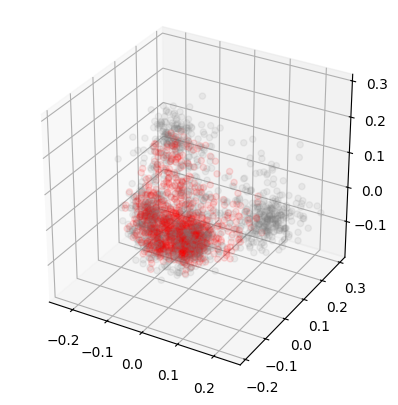

In [ ]:
from utils.visualize_clusters import plot_clusters
from umap import UMAP
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

umap = UMAP(n_components=2).fit(X)
pca = PCA(n_components=3).fit(X)
# denstream.is_clustered = False
# i, j = denstream._recluster()
labels = denstream.predict(X)
plot_clusters(pca.transform(X), labels, n_components=3)

pmc_centers = denstream._get_cluster_centers(denstream.c_micro_clusters)
pmc_centers_2d = pca.transform(pmc_centers)
plt.scatter(*pmc_centers_2d.T, marker="+")

# omc_centers = denstream._get_cluster_centers(denstream.o_micro_clusters)
# omc_centers_2d = umap.transform(omc_centers)
# plt.scatter(*omc_centers_2d.T, marker="+", c="C1", alpha=.3)

# for pair in zip(i, j):
#     plt.plot(*np.array([pmc_centers_2d[pair[0]], pmc_centers_2d[pair[1]]]).T, c="black", alpha=0.1)

plt.show()

In [87]:
print(denstream.clustering)

[ 0 -1]


### Relevant Distributions

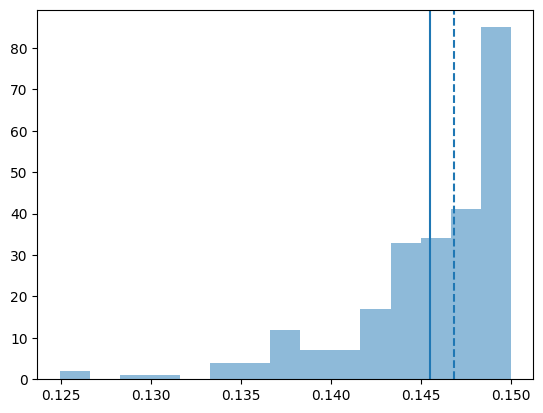

Mean: 0.1454793770792872
Std: 0.004461112780300646


In [344]:
# Radius of p-micro-clusters
radii = np.array([c.radius for c in denstream.c_micro_clusters])
plt.hist(radii, bins=15, density=False, alpha=0.5)
plt.axvline(np.mean(radii), color="C0")
plt.axvline(np.median(radii), color="C0", linestyle="--")
plt.show()

print("Mean:", radii.mean())
print("Std:", radii.std())

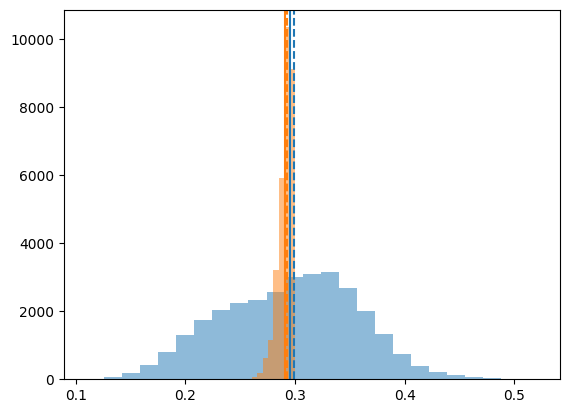

Mean: 0.2951763906057739
Std: 0.06177844327428105


In [346]:
from scipy.spatial.distance import pdist

# Distances between p-micro-clusters
centers = denstream._get_cluster_centers(denstream.c_micro_clusters)
distances = pdist(centers)
plt.hist(distances, bins=25, density=False, alpha=0.5, label="Distances")
plt.axvline(distances.mean(), color="C0")
plt.axvline(np.median(distances), color="C0", linestyle="--")


# Distribution of pairwise radii sums
radii_sums = radii[None] + radii[:,None]
radii_sums = radii_sums[np.triu_indices(len(radii_sums), k=1)]
plt.hist(radii_sums, bins=10, density=False, alpha=0.5, label="Pairwise Radii Sums")
plt.axvline(np.mean(radii_sums), color="C1")
plt.axvline(np.median(radii_sums), color="C1", linestyle="--")

plt.show()

print("Mean:", distances.mean())
print("Std:", distances.std())

In [69]:
print(X[:2])

[[ 0.01007851  0.06520559  0.03504637  0.09134252 -0.04685255  0.02764612
   0.0779185  -0.00430528  0.06508105 -0.05166233 -0.00442669 -0.00784599
   0.04306291 -0.01118667  0.02379245  0.00309038  0.03199976 -0.03315047
   0.03149154  0.06063461 -0.03429394 -0.0189639   0.01558478  0.09360755
  -0.00511726 -0.04026742  0.03433371  0.00162173  0.00898603 -0.05391317
   0.14405696 -0.08824969 -0.01665569 -0.01869297 -0.05555797 -0.01534728
  -0.00877808  0.0437192  -0.02795112 -0.03672141  0.04620199  0.03381868
  -0.03796265 -0.02791935 -0.08157056  0.01021943  0.0359981  -0.03032098]
 [-0.01990343  0.00259883 -0.00380312  0.00299324 -0.01246677 -0.01355884
   0.03297133 -0.00625546  0.03407067 -0.06950022  0.07215153  0.00112266
  -0.01424253  0.00832665  0.05257377  0.0105975  -0.03746896 -0.02294173
   0.00068777 -0.05908491 -0.01669798  0.05285194  0.02380929 -0.00336742
  -0.02406888 -0.00513715 -0.06556267  0.01562289  0.0299945  -0.02776575
   0.22736344  0.00029447  0.00477028

In [68]:
from scipy.spatial.distance import pdist

c_micro_clusters = denstream.c_micro_clusters
cmc_centers = denstream._get_cluster_centers(c_micro_clusters)
print(cmc_centers)
distances = pdist(cmc_centers)
np.max(distances)
plt.scatter(*umap.transform(cmc_centers).T)

[[-0.00873568  0.01823757  0.00293578  0.02346001 -0.01331201  0.00700872
   0.01950562 -0.01244132  0.0234285  -0.01879729  0.0160753   0.02487585
   0.02452056  0.02068476  0.01841135 -0.0039388  -0.00022557  0.00690716
   0.01065426  0.01094309 -0.00243021  0.00312189  0.00435953  0.02040318
   0.00452479 -0.00730526  0.00548928 -0.01102417  0.01850121 -0.00972139
   0.07043567 -0.01667709  0.00215951 -0.01906084  0.0047198  -0.00623972
   0.02147775  0.00619765  0.03177237 -0.00672395  0.02233959  0.00439261
  -0.00732208 -0.00566049 -0.0036105  -0.00786985  0.00248186 -0.02267496]]


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
t = denstream.timestamp
weights = [c.calc_weight(t) for c in core_micro_clusters]
print("Average weight:", np.mean(weights))
print("C1\tC1_w\tC2\tC2_w\tDist\tWeighted Dist")
for i, c1 in enumerate(core_micro_clusters):
    for j, c2 in enumerate(core_micro_clusters):
        if i == j:
            continue
        c2_weight = c2.calc_weight(t)
        dist = np.linalg.norm(c1.calc_center(t) - c2.calc_center(t))
        weighted_dist = dist / np.sqrt(c1_weight * c2_weight)
        print(f"{i}\t{round(weights[i],2)}\t{j}\t{round(weights[j],2)}\t{round(dist,4)}\t{round(weighted_dist*10,4)}")

Average weight: 11.425702126981173
C1	C1_w	C2	C2_w	Dist	Weighted Dist
0	27.75	1	22.7	4.5398	4.6465
0	27.75	2	16.82	0.9912	1.1787
0	27.75	3	11.77	4.9744	7.0705
0	27.75	4	14.3	4.496	5.7993
0	27.75	5	5.05	5.2786	11.4608
0	27.75	6	18.5	6.3675	7.2199
0	27.75	7	16.82	3.6879	4.3857
0	27.75	8	7.57	5.1373	9.1073
0	27.75	9	13.45	3.8412	5.1072
0	27.75	10	8.41	5.3271	8.9591
0	27.75	11	9.25	5.1224	8.214
0	27.75	12	14.3	4.8215	6.2191
0	27.75	13	15.14	4.9117	6.157
0	27.75	14	21.86	6.0071	6.2654
0	27.75	15	16.14	0.6952	0.844
0	27.75	16	9.25	4.9144	7.8804
0	27.75	17	14.3	4.3033	5.5508
0	27.75	18	11.77	5.5457	7.8825
0	27.75	19	17.66	4.1094	4.7691
0	27.75	20	18.5	4.3881	4.9755
0	27.75	21	10.09	4.7486	7.2903
0	27.75	22	19.34	4.4465	4.9309
0	27.75	23	13.45	4.2458	5.6451
0	27.75	24	19.34	4.2072	4.6655
0	27.75	25	8.41	4.9894	8.3911
0	27.75	26	23.55	4.874	4.8986
0	27.75	27	11.77	5.5699	7.9169
0	27.75	28	18.5	1.6945	1.9213
0	27.75	29	7.57	4.8417	8.5832
0	27.75	30	10.09	5.6331	8.6483
0	27.75	31	20.18	4.7972	5.2

***Issues I have with the DenStream implementation as it stands***
- Implementation initialization is not consistent with the paper, uses $\mu$ instead of $\beta \mu$ as a threshold
- Implementation DEFINITELY IS overwriting o-micro-clusters (see the _merge method, specifically where o-micro-clusters become p-micro-clusters and where new o-micro-clusters are created)
    * The below example demonstrates the problem with the current implementation
    * Also breaks convention in the _merge method and sets merged_status to True at the very end for no reason (it wasn't merged into a p-micro-cluster and that variable isn't used again anyway)
    * This issue shows up again in the learn_one method, with both the p-micro-clusters and o-micro-clusters (the .pop() method causes the same issue as the _merge method)
- Clustering is performed each time the predict_one method is called, which is inefficient when doing a lot of predictions without updating the model
- When not initialized, the model should not predict anything, but the implementation returns class index 0 (should be an noise index like -1, or should throw error)
- There is a bug on line 387 in the predict_one method where the clustering adds neighbors of the neighbors that have already been labelled when it should add the ones that have not been labelled. As it stands, neighbors of neighbors are added and then removed by the earlier if statement on line 378.
- The final clustering of the implementation does not allow for noise/outliers since it just naively finds the closest cluster to each point
- The implementation does not do anything that the paper describes about accounting for deletion of micro-clusters, such as the overlapping problem in Figure 3

***NOTE***: Definition 4.1 in the paper is not explicit in whether $c_p$ AND $c_q$ must both be core-micro-clusters, or just $c_q$, and $c_p$ can be just a p-micro-cluster. The implementation assumes the former, which I agree with, since that allows direct density reachability to be commutative.

# Visualization

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from umap import UMAP
from river import stream
from utils.visualize_clusters import get_cluster_colormap


def animation(clusterer, X, reduction, plot_micro_clusters=False, interval=20, **kwargs):
    """Create an animation object that visualizes the streamed clustering process.
    
    Parameters:
        clusterer: The clustering model to use in visualizing the data stream
        X (np.ndarray): The set of data points to visualize
        reduction: The reduction model to use for reducing the data points to 2D
        interval (int): The time interval between frames in the animation (ms)
    """
    # Reduce the data points to 2D
    def reduce(X):
        if reduction is None:
            return X
        return reduction.transform(X)

    X_2d = reduce(X)
    if X_2d.shape[1] > 2:
        raise ValueError("The reduced data points have more than 2 dimensions, so they cannot be plotted."
                         "Please provide a reduction with 2 dimensions to plot the clusters.")

    # Initialize variables
    data_stream = stream.iter_array(X)
    labels = -1 * np.ones(len(X))

    # Initialize figure
    fig, ax = plt.subplots()
    n_cmap_clusters = 10   # Initial number of cluster colors to pull from the colormap
    cmap, norm = get_cluster_colormap(num_clusters=n_cmap_clusters, outliers=True, cmap="hsv")

    # Initialize scatter plot (boundaries, size, color, alpha, etc.)
    points = ax.scatter(*X_2d.T, s=10, c=labels, cmap=cmap, norm=norm, alpha=0.05)
    centers = ax.scatter([], [], s=100, c=[], marker="+", cmap=cmap, norm=norm, alpha=1.0)  
    micro_clusters = ax.scatter([], [], s=100, c=[], marker="*", cmap=cmap, norm=norm, alpha=1.0)
        
    def init_func():
        points.set_offsets(X_2d[:0])
        points.set_array(labels[:0])
        return points, centers, micro_clusters

    def update(i, labels, n_cmap_clusters):
        # Add the new point to the clusterer
        clusterer.learn_one(next(data_stream)[0])  

        # Update clusters every stream time step
        if i % clusterer.stream_speed == 0 and i >= clusterer.n_samples_init:   
            labels[:i+1] = clusterer.predict(X[:i+1])
            if n_cmap_clusters < clusterer.n_clusters:  # Update the colormap to account for more clusters
                clusterer._recluster()
                n_cmap_clusters = clusterer.n_clusters
                cmap, norm = get_cluster_colormap(num_clusters=n_cmap_clusters, outliers=True, cmap="hsv")
                points.set_cmap(cmap)
                points.set_norm(norm)
                centers.set_cmap(cmap)
                centers.set_norm(norm)
                micro_clusters.set_cmap(cmap)
                micro_clusters.set_norm(norm)
            centers_2d = reduce(clusterer.centers)   # Update the cluster center points
            centers.set_offsets(centers_2d)
            centers.set_array(np.arange(clusterer.n_clusters))
            if plot_micro_clusters:
                micro_clusters_2d = reduce([list(mc.calc_center(clusterer.timestamp).values()) for mc in clusterer.p_micro_clusters.values()])
                micro_clusters.set_offsets(micro_clusters_2d)
                micro_clusters.set_array(np.arange(len(clusterer.p_micro_clusters)))

        # Update the data points
        points.set_offsets(X_2d[:i+1])
        points.set_array(labels[:i+1])

        return points, centers

    # Return the animation object
    return FuncAnimation(fig, update, init_func=init_func, frames=len(X), interval=interval, blit=True,
                         fargs=(labels, n_cmap_clusters), **kwargs)

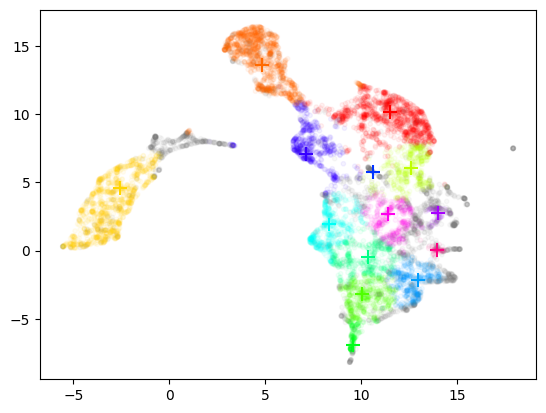

In [ ]:
clusterer = DenStreamAnalyze(
    decaying_factor=0.25,
    beta=0.75,
    mu=2.,
    epsilon=1.,
    n_samples_init=250,
    stream_speed=250,
)
X = embeddings["reduced"].numpy()[:10000]
reduction = UMAP(n_components=2).fit(X)

animation(clusterer, X, reduction, interval=2).save("denstream.mp4", writer="ffmpeg")

In [ ]:
temp: dict[int, int] = {i:2*i for i in range(10)}   # Dictionary of values
print(temp)
del temp[2]                         # When deleting, the length is decremented
print(temp)
temp[len(temp)] = 100               # Then, when assigning again, the length is equal to an old key, and that value is overwritten
print(temp)                         # See, the value for key 9 is now 100, and the 18 is lost

{0: 0, 1: 2, 2: 4, 3: 6, 4: 8, 5: 10, 6: 12, 7: 14, 8: 16, 9: 18}
{0: 0, 1: 2, 3: 6, 4: 8, 5: 10, 6: 12, 7: 14, 8: 16, 9: 18}
{0: 0, 1: 2, 3: 6, 4: 8, 5: 10, 6: 12, 7: 14, 8: 16, 9: 100}


## Next steps:

1. Generate a synthetic dataset where you can track clusters over time, such as multiple gaussian blobs whose means move around over time
2. Maybe look into contributing to DenStream implementation in River library (?)
3. Make the animation function part of the utils.visualize_clusters file
4. Do this stuff for DBStream
5. Figure out how to do hyperparameter optimization for these streaming clustering models

## Synthetic Data

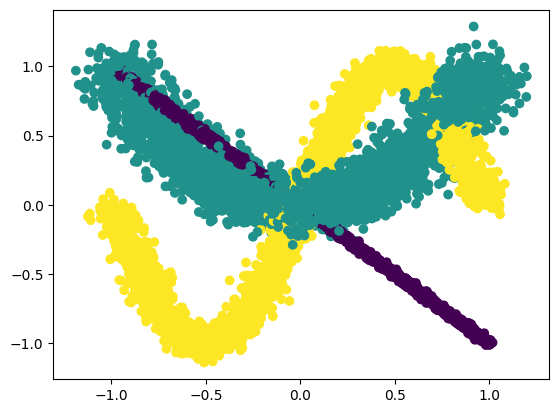

In [ ]:
from sklearn.datasets import make_blobs
import numpy as np

num_points=10000
functions = [lambda t: np.array([t,-t]), 
            lambda t: np.array([t,t**2]), 
            lambda t: np.array([t,np.sin(np.pi*t)])]
f_std = [0.01, 0.1, 0.05]
T = np.linspace(-1, 1, num_points)

labels = np.random.choice(len(functions), num_points)
sampled_centers = np.array([[functions[i](t)] for i, t in zip(labels, T)])
data = np.vstack([make_blobs(n_samples=1, centers=c, n_features=2, cluster_std=f_std[l])[0] 
                    for c, l in zip(sampled_centers, labels)])

plt.scatter(*data.T, c=labels, cmap="viridis")
plt.show()


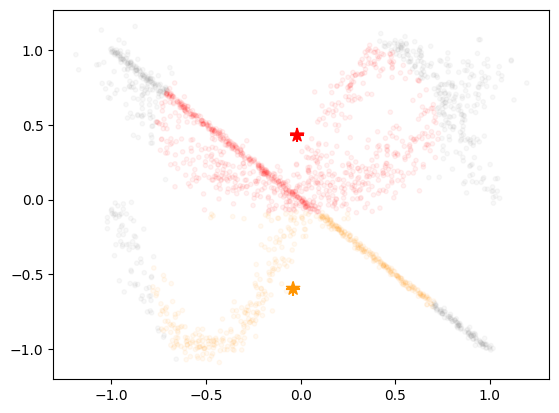

In [ ]:
clusterer = DenStreamAnalyze(
    decaying_factor=0.5,
    beta=0.75,
    mu=2.,
    epsilon=.75,
    n_samples_init=250,
    stream_speed=50,
)

animation(clusterer, data[::5], plot_micro_clusters=True, reduction=None, interval=2).save("denstream_synthetic.mp4", writer="ffmpeg")

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from river import stream
from umap import UMAP

clusterer = DenStreamAnalyze(
    decaying_factor=0.25,
    beta=0.75,
    mu=2.,
    epsilon=1.,
    n_samples_init=100,
    stream_speed=100,
)
X = embeddings["reduced"].numpy()[:1000]

# Train the visualization reduction
umap = UMAP(n_components=2).fit(X)     # Would PCA be better for this?

# TODO: Incorporate these plotting functions into my custom class
# TODO: Add an option to let alpha be a function of point weight
# TODO: Add option to plot cluster centers/radii (does radius make sense in the 2d space after reduction?)
# TODO: Maybe add a way to track what micro-cluster a point is added to when learned (to track noise points better)?
# TODO: Get the animation working (eventually?)

# TODO: Finally, do all this for DBStream and compare the two   
#       I will need metric(s) to compare the clusters

for i, (x, _) in enumerate(stream.iter_array(X)):
    clusterer.learn_one(x)  
    if i % clusterer.stream_speed == 0 and i >= clusterer.n_samples_init:
        clusterer.plot_clusters(X[:i+1], reduction=umap)
        plt.show()

In [ ]:
# %matplotlib ipympl

<Axes: >

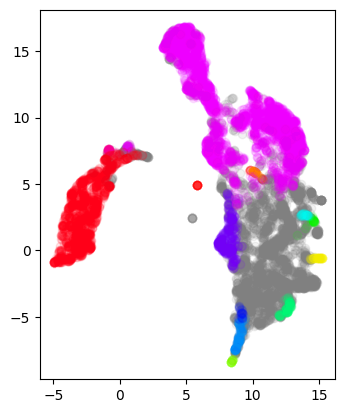

In [ ]:
from utils.visualize_clusters import plot_clusters

plot_clusters(embeddings["reduced"], clusters.labels_, n_components=2)

<Axes: >

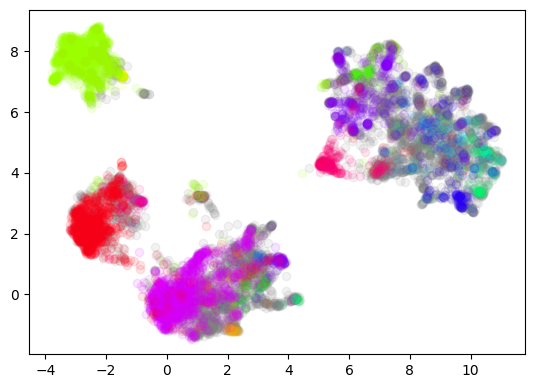

In [ ]:
plot_clusters(embeddings["full"], clusters.labels_, n_components=2)

#### Cluster with Cosine Similarity Distance

In [ ]:
import torch

cos_sim = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
similarity_matrix = cos_sim(embeddings["reduced"].unsqueeze(0), embeddings["reduced"].unsqueeze(1))

In [ ]:
similarity_matrix.shape

torch.Size([10000, 10000])

In [ ]:
1-similarity_matrix[:5,:5]

tensor([[ 0.0000e+00,  1.2755e-03,  6.1562e-02,  4.1294e-04,  5.2545e-01],
        [ 1.2755e-03,  5.9605e-08,  6.2085e-02,  1.4993e-03,  5.1614e-01],
        [ 6.1562e-02,  6.2085e-02,  1.1921e-07,  5.5449e-02,  7.4853e-01],
        [ 4.1294e-04,  1.4993e-03,  5.5449e-02, -1.1921e-07,  5.3123e-01],
        [ 5.2545e-01,  5.1614e-01,  7.4853e-01,  5.3123e-01, -1.1921e-07]])

In [ ]:
from sklearn import cluster

clusterer = cluster.HDBSCAN(min_cluster_size=20, min_samples=4, metric='precomputed', cluster_selection_method='eom')

In [ ]:
clusters = clusterer.fit((1-similarity_matrix).numpy())

In [ ]:
import numpy as np

labels, counts = np.unique(clusters.labels_, return_counts=True)
print("Labels:", labels)
print("Counts:", counts)

Labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Counts: [6168   25   43   22   47   21   28   20   72   43   20   25   53  135
  330   25   34  831   27  246   24  870  891]


<Axes: >

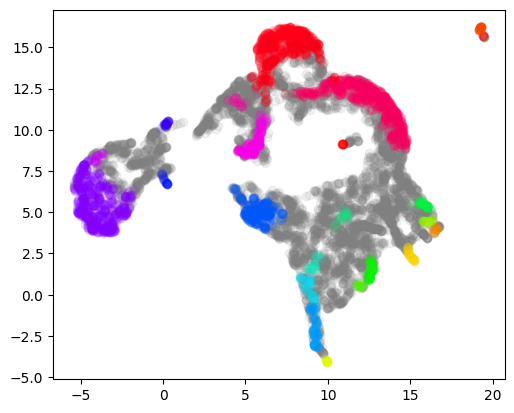

In [ ]:
plot_clusters(embeddings["reduced"], clusters.labels_, n_components=2, metric="cosine")

<Axes: >

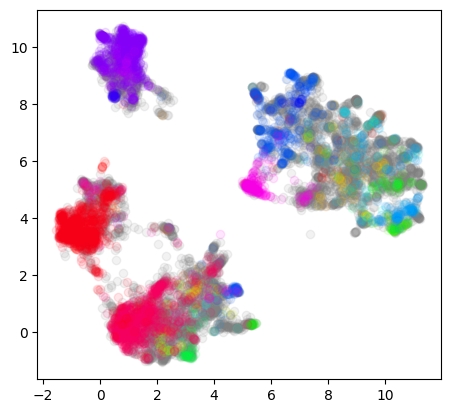

In [ ]:
plot_clusters(embeddings["full"], clusters.labels_, n_components=2, metric="cosine")

#### Cluster with L2-Normalized Euclidean Distance

In [ ]:
import torch.nn.functional as F

def l2_normalize(batch):
    return {"reduced_normalized": F.normalize(batch["reduced"], p=2, dim=1),
            "full_normalized": F.normalize(batch["full"], p=2, dim=1)}

embeddings = embeddings.map(l2_normalize, batched=True, batch_size=1000)

In [ ]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=20, min_samples=5, metric='euclidean', cluster_selection_method='eom')

In [ ]:
clusters = clusterer.fit(embeddings["reduced_normalized"].numpy())

In [ ]:
import numpy as np

labels, counts = np.unique(clusters.labels_, return_counts=True)
print("Labels:", labels)
print("Counts:", counts)

Labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Counts: [4084   25   43   47   21   24   81   29  116   21  359 3664   38 1448]


<Axes: >

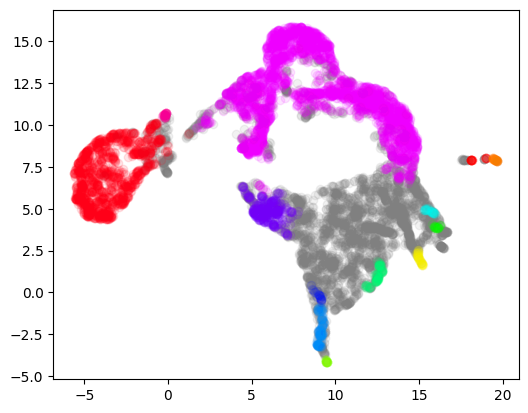

In [ ]:
plot_clusters(embeddings["reduced_normalized"], clusters.labels_, n_components=2, metric="euclidean")

<Axes: >

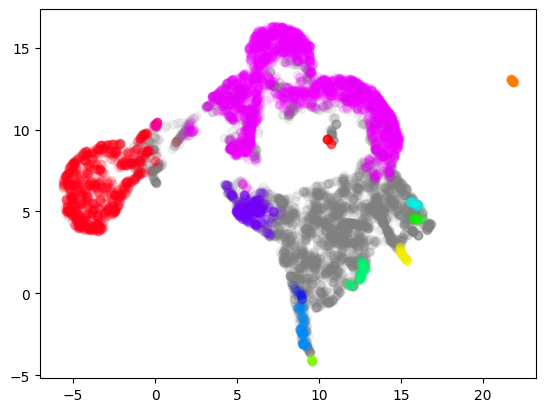

In [ ]:
plot_clusters(embeddings["reduced_normalized"], clusters.labels_, n_components=2, metric="cosine")

<Axes: >

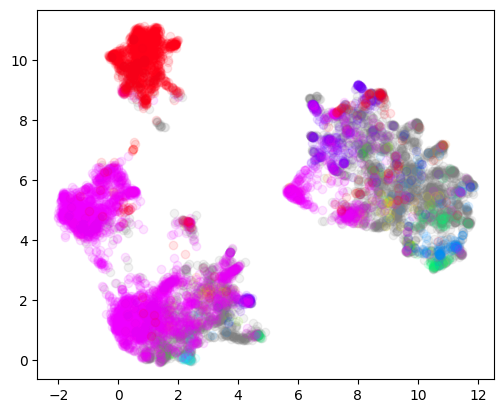

In [ ]:
plot_clusters(embeddings["full_normalized"], clusters.labels_, n_components=2, metric="euclidean")